# Twitter US Airline Sentiment Analysis using ULMFiT

In this notebook, I fine-tune a forward and backward langauge ULMFiT model to get to <b>82.7%</b> accuracy on the Twitter US Airline Sentiment dataset available on kaggle at https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data#.
I have used the techniques described in https://arxiv.org/pdf/1801.06146.pdf and https://course.fast.ai/videos/?lesson=12 as the main reference for this sentiment analysis.

These techniques include:
<ul>
    <li>Discriminative fine-tuning</li>
    <li>Slanted triangular learning rates</li>
    <li>Gradual unfreezing</li>
</ul>
I have cited my sources for the techniques applied along with my reasoning for each step within the text blocks preceeding the code implemented.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.text import *
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Visualizing and Preprocessing the data

The first step is to load and explore the data. Since the aim of the notebook is to use an RNN for the prediction of sentiment, the text column becomes the richest source of data for the sentiment analysis in the dataset. However the other data does also provide some keen insights into the structuring of the data which can offer information about the structure of this dataset.

### References:<br>
https://www.kaggle.com/wesleyliao3/sentiment-analysis-using-rnn-lstm-ulmfit <br>
https://www.kaggle.com/sanjanavoona1043/sentimental-analysis-using-nlp-for-begineers <br>
https://www.kaggle.com/anjanatiha/sentiment-analysis-with-lstm-cnn <br>
https://www.kaggle.com/nursah/airline-tweets-sentiment-analysis <br>


In [2]:
df =  pd.read_csv('Tweets.csv')#loading the dataset
df.head() #previewing the intial columns of the dataset

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.isna().sum()#looking for null values in the columns
#particularly in the tweet and airline sentiment columns which are of primary focus

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

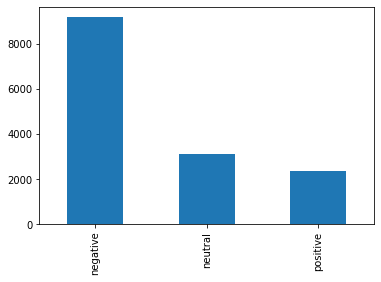

In [4]:
df['airline_sentiment'].value_counts().plot(kind='bar') # Exploring the distribution of the sentiments accross the dataset as a whole

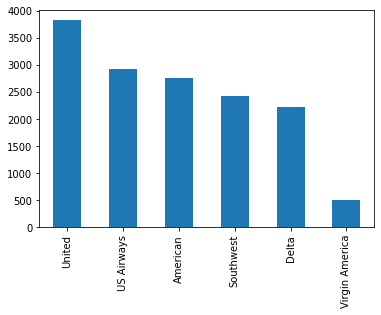

In [5]:
df['airline'].value_counts().plot(kind='bar') # Exploring the distribution of the samples for each airline

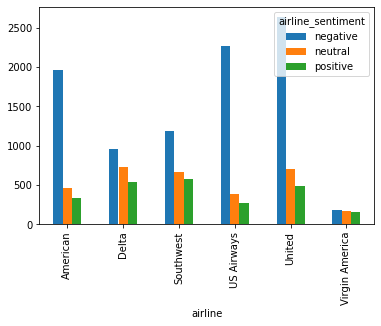

In [6]:
airline_sentiment = df.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar') # Exploring the distribution of sentiments according to each airline

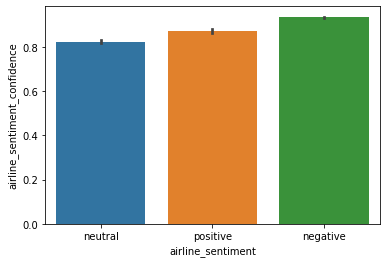

In [7]:
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=df) #Exploring the distribution of airline sentiment confidence by sentiment

[]

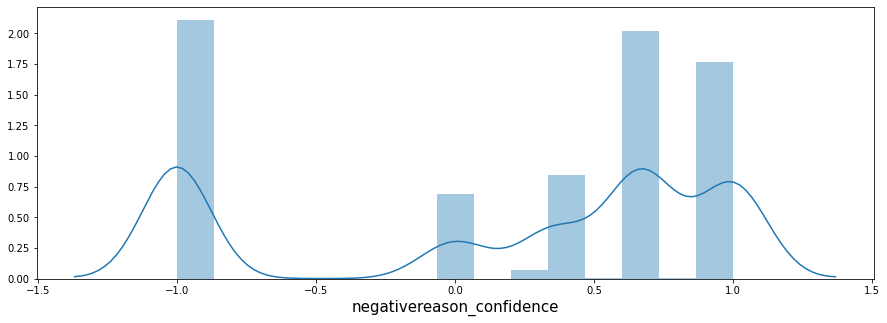

In [8]:
#Exploring the distribution of confidence for negative sentiments, Negative sentiments form the largest samples size
x = df["negativereason_confidence"].fillna(-1)

figsize=(15, 5)

ticksize = 10
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)
sns.distplot(x)
plt.plot()

### Conclusion from the basic data visualisation

The dataset is fairly unbalanced as is typically the case with review data which tends to be more negative as there is a higher inclination to leave a review if the quality of a product or service is unsatisfactory.

To deal with this I will consider the proportion of imbalance in the dataset and decide on benchmarks to assess the ability of the model to deal with imbalance accordingly. 

## Preprocessing the dataset
For pre-processing the text column of the dataset I have used this repository from Dimitrios Effrosynidis which specializes in preprocessing data for twitter sentiment analysis. The repository is available at https://github.com/Deffro/text-preprocessing-techniques

The I have avoided steps like lemmatization, stopwords removal, stemming and removing mentions since I feel like they take away valuable information, particularly when we're using a recurrent neural network which can infer information about the state from the data otherwise removed.

### References:
https://github.com/Deffro/text-preprocessing-techniques <br>
https://course.fast.ai/videos/?lesson=12<br>
https://forums.fast.ai/t/class-imbalance-in-a-multi-label-scenario-ulmfit/50883/6

In [9]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def removeSpecialCharacters(text):
    """ Removes puncatuations from text """
    return re.sub(r'[^\w\s]',' ',text)        

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]

## Replace Negations Begin ###

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
      for lemma in syn.lemmas():
        for antonym in lemma.antonyms():
          antonyms.add(antonym.name())
    if len(antonyms) == 1:
      return antonyms.pop()
    else:
      return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
      word = text[i]
      if word == 'not' and i+1 < l:
        ant = replace(text[i+1])
        if ant:
          words.append(ant)
          i += 2
          continue
      words.append(word)
      i += 1
    return words

def replaceNegationsText(text):
    """ Replace negations from the entire text string (not a single token) """
    tokens = word_tokenize(text)
    tokens = replaceNegations(tokens) # Technique 6: finds "not" and antonym 
                                      # for the next word and if found, replaces not 
                                      # and the next word with the antonym
    onlyOneSentence = " ".join(tokens) # form again the sentence from the list of tokens
    return onlyOneSentence

def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text


def lowercase(text):
    """ Make all characters lowercase """
    return text.lower()

In [10]:
# Applying the preprocessing techniques
df.text = df.text.apply(removeUnicode).apply(lowercase).apply(replaceURL).apply(removeHashtagInFrontOfWord).apply(replaceContraction).apply(removeNumbers).apply(removeEmoticons).apply(removeSpecialCharacters).apply(replaceNegationsText)

## Building and fine-tuning the model
To build and fine-tune the model I have used several references which are mentioned below but the key references include the original ULMFiT paper at https://arxiv.org/abs/1801.06146 and the github example for ULMFiT given at https://github.com/fastai/fastai/blob/master/examples/ULMFit.ipynb

### References:
https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/#extresults <br>
https://course.fast.ai/videos/?lesson=12<br>
https://docs.fast.ai/text.html <br>
https://docs.fast.ai/text.learner.html#text_classifier_learner <br>
https://docs.fast.ai/text.data.html#TextLMDataBunch <br>
https://forums.fast.ai/t/class-imbalance-in-a-multi-label-scenario-ulmfit/50883/6 <br>
https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde <br>
https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data# <br>
https://gist.github.com/manojps/ffd382ee97d173f14f9ac5075fe1d1af <br>

The first step is to load the pre-trained models.  I download the ULMFiT pretrained models weights on WikiText-103 dataset and 
also use the LSTM model weights pre-trained on the same dataset using the following commands.

In [11]:
#!wget http://files.fast.ai/models/wt103/
#!wget http://files.fast.ai/models/wt103_v1/lstm_wt103.pth
#!wget http://files.fast.ai/models/wt103_v1/itos_wt103.pkl

Then I seperate the text and sentiment columns from the original dataframe since these are the most useful for the model.

In [12]:
df = df[['airline_sentiment', 'text']]
df = df.rename(columns={'airline_sentiment':'labels'})

Then I create the training and testing datasets using a standard 80:20 split and I have also found the percentage of negative samples in each dataset which will be the benchmarks for checking if the model is able to cope with imbalance.

In [14]:
# Dividing the dataset into training and test sets

test_df = df.sample(frac=0.2) # setting the 80:20 split
print("Percentage of negative samples: ", (100*len(test_df[test_df.labels=='negative'])/len(test_df.labels)))

train_df = df.drop(test_df.index) # setting the rest as training set
print("Percentage of negative samples: ", (100*len(train_df[train_df.labels=='negative'])/len(train_df.labels)))

# Prepare data for language model
data_lm = TextLMDataBunch.from_df(train_df = train_df, valid_df = test_df, path = "")

# Prepare data for classifier model
data_clas = TextClasDataBunch.from_df(path = "", train_df = train_df, valid_df = test_df,vocab=data_lm.train_ds.vocab, bs=16)

Percentage of negative samples:  61.98770491803279
Percentage of negative samples:  62.86714480874317


60% the dataset is negative, this would result in an accuracy of 60% if we just randomly drew labels for each tweet, every third tweet would be guessed right on average. Hence we can use this as a benchmark for the performance of our model and it's ability to deal with imbalance.

### References:
https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/#overviewulmfit

## Language model learner

Since I cannot directly train a bidirectional RNN for language modeling, I follow fastai's idea to ensemble a forward and backward model. fastai also provides a pretrained forward and backawrd model which can fine-tune the pretrained backward model as well.

I first re-train and fine-tune the forward language model using the AWD_LSTM model since it automatically uses pretrained weights.Ialso use Mixed Precision Training to train part of the model in FP16 precision, and also speeds up training by a factor 2 to 3 on modern GPUs.

In [15]:
learn = language_model_learner(data=data_lm, arch=AWD_LSTM,drop_mult=0.5)
learn = learn.to_fp16(clip=0.1)

I also try to estimate the best learning rate for the model using the in built lr_find function and settle on a learning rate of 2e-2.

I've also used the fit_one_cycle which uses the 1cycle policy which is described by Leslie Smith which works better than the regular fit() function.

### References:
https://arxiv.org/abs/1803.09820 <br>
https://sgugger.github.io/the-1cycle-policy.html

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


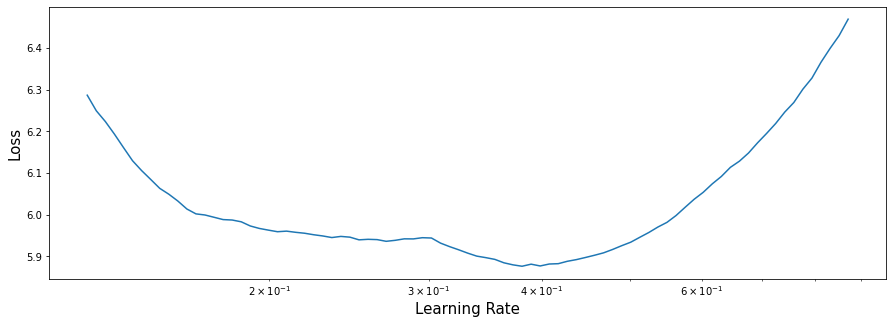

In [16]:
learn.lr_find(start_lr=1e-1, end_lr=1e0)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,5.188676,4.541378,0.197287,00:24


Then we unfreeze the whole model and fine-tune it.

In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.437553,4.410529,0.211968,00:31
1,4.327713,4.326780,0.222064,00:31
2,4.176690,4.294850,0.222459,00:31
3,3.934331,4.275640,0.230889,00:31
4,3.613740,4.335411,0.229258,00:31
5,3.259193,4.412389,0.230357,00:32
6,2.914467,4.530103,0.226923,00:31
7,2.637608,4.586695,0.225893,00:31
8,2.427841,4.654379,0.225240,00:31
9,2.298579,4.679646,0.224193,00:32


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.

In [19]:
learn.save_encoder('fwd_enc')

Similarly, I do the same for the Backward Language Model. Except I load the data for the backward model and pqss the flag backwards=True.

In [20]:
bs, bptt = 16, 80
data_lm.save('data_lm.pkl')
path = '/content/'
data_bwd = load_data(path, 'data_lm.pkl', bs=bs, bptt=bptt, backwards=True)

In [21]:
learn = language_model_learner(data_bwd, AWD_LSTM)
learn = learn.to_fp16(clip=0.1)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


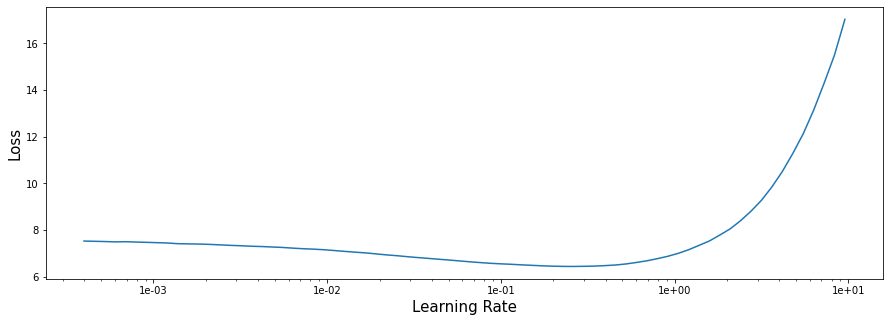

In [25]:
learn.lr_find(start_lr=1e-4, end_lr=1e2)
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,5.036266,4.555306,0.242296,00:40


In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.532536,4.428856,0.254124,00:51
1,4.402817,4.332869,0.263826,00:50
2,4.256989,4.278537,0.269095,00:50
3,4.031388,4.252894,0.274782,00:50
4,3.775162,4.237673,0.279070,00:50
5,3.509618,4.272671,0.278834,00:51
6,3.239058,4.317831,0.277889,00:50
7,2.996392,4.381732,0.278325,00:50
8,2.847748,4.412476,0.277707,00:50
9,2.751092,4.436616,0.277653,00:50


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.

In [29]:
learn.save_encoder('bwd_enc')

## Building the Classifier

Now that the Language models are ready, I build the classifier using an LSTM. I also use the novel discriminitive fine-tuning technique described in the original ULMFiT paper.

First I load the data, I loaded data for both the forward and backward ensemble.

In [30]:
data_clas.save('data_clas.pkl')
data_clas_bwd = load_data(path, 'data_clas.pkl', bs=bs, backwards=True)

Then I load the classifier, since there is an imbalance in the dataset I've also set the precision and recall metrics to get a sense of the ability of the model. I have also settled on a learning rate 1e-1.

In [31]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn.load_encoder('fwd_enc')
recall = Recall(average='macro')
precision = Precision(average='macro')
learn.metrics=[accuracy, recall, precision]

In [32]:
lr = 1e-1
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.734563,0.626551,0.746243,0.621366,0.719828,00:28


In [33]:
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.657859,0.544400,0.783811,0.694191,0.747674,00:32


In [34]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.659570,0.521124,0.793716,0.671363,0.795287,00:48


Unfreeze all the layers and fine-tune the whole model.

In [35]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.553516,0.491693,0.808402,0.738851,0.773037,01:03
1,0.473785,0.485699,0.828210,0.773628,0.786447,01:03


In [36]:
learn.save('fwd_clas')

Repeating the same steps for the backward classifier using the backwards encoder and appropriate data

In [37]:
learn_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_bwd.load_encoder('bwd_enc')
recall = Recall(average='macro')
precision = Precision(average='macro')
learn_bwd.metrics=[accuracy, recall, precision]

In [38]:
learn_bwd.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.683670,0.626077,0.740779,0.611097,0.708211,00:28


In [39]:
learn_bwd.freeze_to(-2)
lr /= 2
learn_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.684288,0.570131,0.775273,0.658147,0.756614,00:33


In [40]:
learn_bwd.unfreeze()
lr /= 5
learn_bwd.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.628138,0.534886,0.790642,0.684090,0.773996,01:03
1,0.547654,0.528931,0.796790,0.717188,0.752017,01:03


In [41]:
learn_bwd.save('bwd_clas')

## Ensembling the two models

For the final results, I take the average of the predictions of the forward and the backward models and calculate the final accuracy of the model.

In [42]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)

In [43]:
pred_bwd,lbl_bwd = learn_bwd.get_preds(ordered=True)

In [44]:
final_pred = (pred_fwd+pred_bwd)/2

In [45]:
accuracy(final_pred, lbl_fwd)

tensor(0.8268)

## Results

I have chosen accuracy for the evaluation metric of the model as it is fairly descriptive of the performance of the system, it allows me to compare my model with other models since it is the most commonly used metric with similar models and for this dataset as well.

The accuracy of the model comes to be around <b>82.7%</b> which beats our benchmark of 60% set earlier which proves that the model is able to handle the imbalance in sentiments from the dataset. It is also a good accuracy when compared with other models available on Kaggle at https://www.kaggle.com/crowdflower/twitter-airline-sentiment/notebooks however it's lower than the results achieved by Sandra Faltl, Michael Schimpke & Constantin Hackober at Humboldt Universitat Zu Berlin who acheive an accuracy of 84.1% in https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/#extresults.

The model's result is also significantly lower than the performance of other datasets such as IMDB movie reviews dataset which achieves a whopping 95% accuracy. This is probably owing to the larger batch size (bs) and the higher backpropogation-through-time (bptt)

### Further improvements can be tested in the model by:
 <ul> 
    <li>Applying different techniques in for preprocessing the data. There are some intrinsic problems with the raw data on kaggle which are highlighted in https://www.kaggle.com/crowdflower/twitter-airline-sentiment/discussion/32636 which if cleaned could further improve the model.</li>
 <li>Further tinkering with the learning rates and other hyper-parameters could be an obvious idea to finding a better fine-tuned  model with a higher accuracy.</li>
 <li> Dealing with the class imbalance by using weighted loss or over/undersampling the data also has potential for improving the result.</li>
</ul>